In [2]:
# Mount Google Drive to save checkpoints and results
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries (optional if already installed in Colab)
!pip install tensorflow
!pip install matplotlib
!pip install Pillow

Mounted at /content/drive


In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv /content/kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 600)


In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/dcgan_data --unzip


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.30G/1.33G [00:17<00:00, 216MB/s]
100% 1.33G/1.33G [00:17<00:00, 82.6MB/s]


In [5]:
import os

image_folder = '/content/dcgan_data/img_align_celeba/img_align_celeba'
num_images = len([name for name in os.listdir(image_folder) if name.endswith('.jpg')])
print(f"Number of images in dataset: {num_images}")


Number of images in dataset: 202599


Saving generator_epoch_270.keras to generator_epoch_270.keras
Saving discriminator_epoch_270.keras to discriminator_epoch_270.keras
Loading generator model from generator_epoch_270.keras
Loading discriminator model from discriminator_epoch_270.keras
成功載入生成器和判別器模型！
Epoch 10, Generator Loss: 0.9117, Discriminator Loss: 1.3313


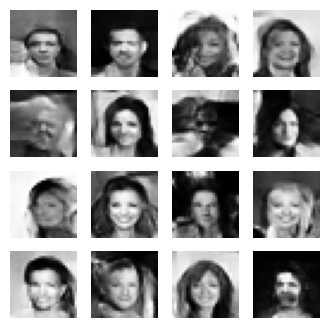

Epoch 20, Generator Loss: 0.9046, Discriminator Loss: 1.3654


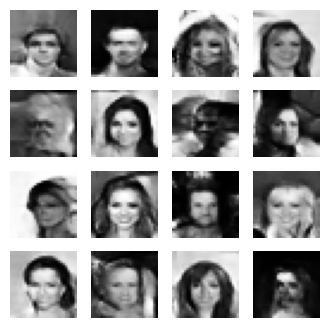

Epoch 30, Generator Loss: 0.9137, Discriminator Loss: 1.2969


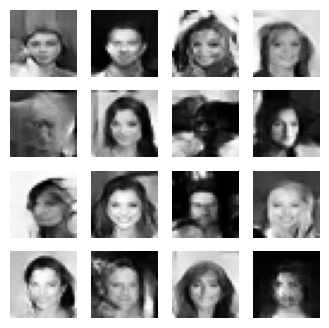

Epoch 40, Generator Loss: 0.8488, Discriminator Loss: 1.3756


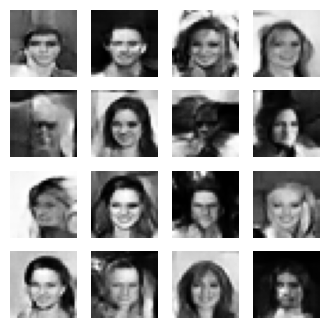

Epoch 50, Generator Loss: 0.8953, Discriminator Loss: 1.3738


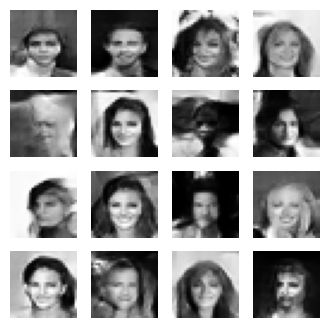

Epoch 60, Generator Loss: 0.8693, Discriminator Loss: 1.3634


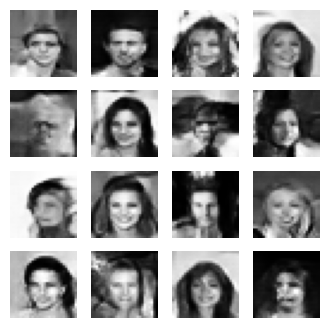

Epoch 70, Generator Loss: 0.8868, Discriminator Loss: 1.3183


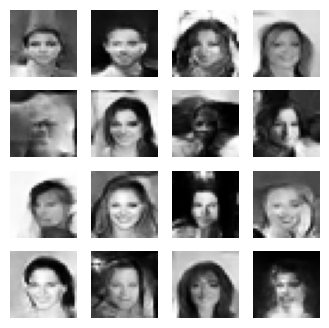

Epoch 80, Generator Loss: 0.8841, Discriminator Loss: 1.3285


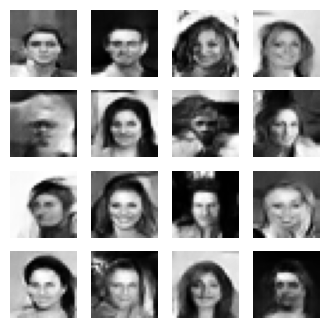

Epoch 90, Generator Loss: 0.9285, Discriminator Loss: 1.4005


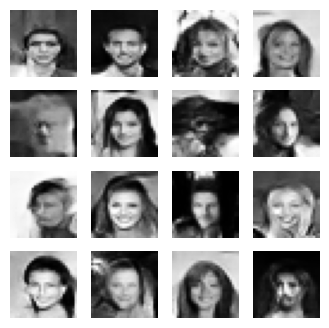

Epoch 100, Generator Loss: 0.8867, Discriminator Loss: 1.3358


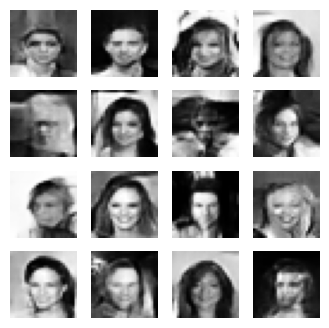

Epoch 110, Generator Loss: 0.8838, Discriminator Loss: 1.3370


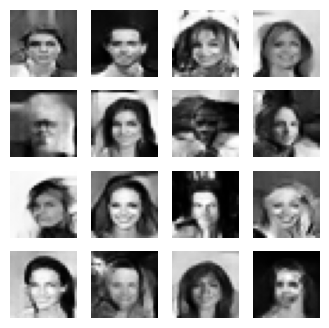

Epoch 120, Generator Loss: 0.8553, Discriminator Loss: 1.4351


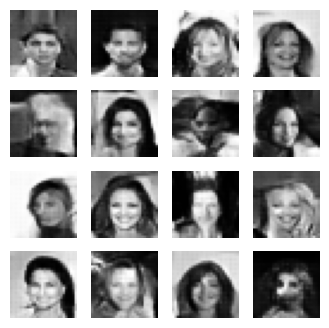

Epoch 130, Generator Loss: 0.8364, Discriminator Loss: 1.3447


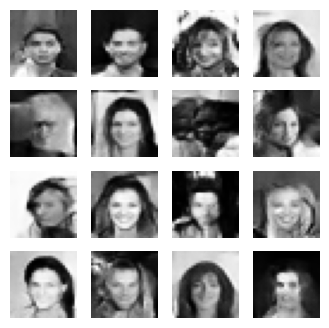

Epoch 140, Generator Loss: 0.9228, Discriminator Loss: 1.2336


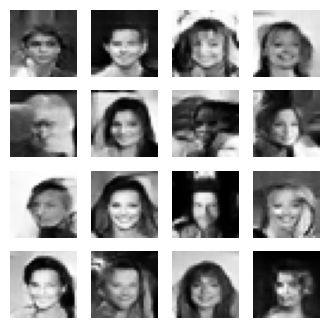

Epoch 150, Generator Loss: 0.8727, Discriminator Loss: 1.3240


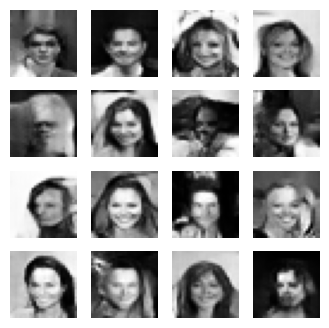

Epoch 160, Generator Loss: 0.8647, Discriminator Loss: 1.3479


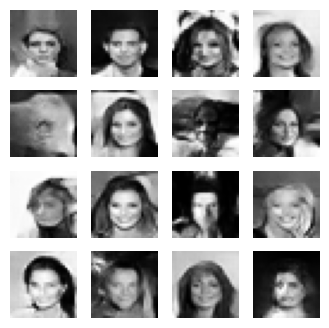

Epoch 170, Generator Loss: 0.8934, Discriminator Loss: 1.2864


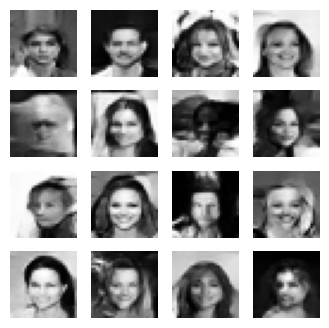

Epoch 180, Generator Loss: 0.8679, Discriminator Loss: 1.3685


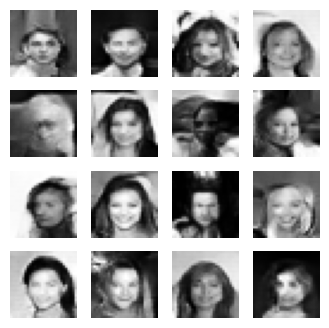

Epoch 190, Generator Loss: 0.8508, Discriminator Loss: 1.3442


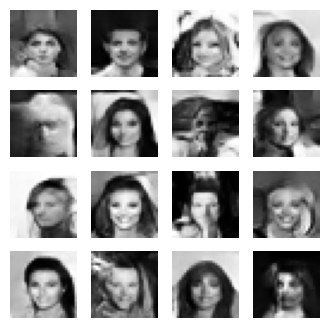

Epoch 200, Generator Loss: 0.8483, Discriminator Loss: 1.3667


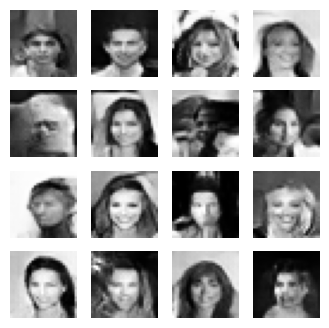

Epoch 210, Generator Loss: 0.9180, Discriminator Loss: 1.3582


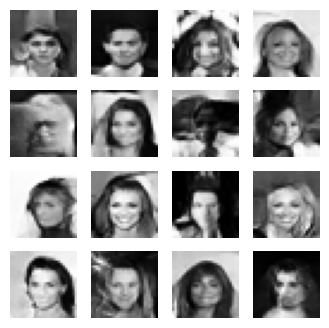

Epoch 220, Generator Loss: 0.8727, Discriminator Loss: 1.3426


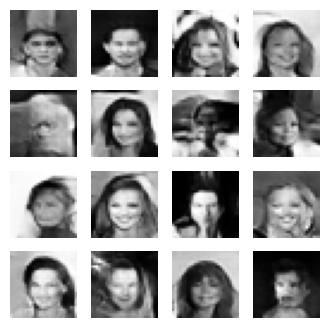

KeyboardInterrupt: 

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import files

# 設定資料夾路徑
image_folder = '/content/dcgan_data/img_align_celeba/img_align_celeba'

# 設定參數
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 300
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# 訓練時使用固定的種子，以便於比較生成結果
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Google Drive 路徑，用於保存模型和結果
save_dir = '/content/drive/MyDrive/dcgan_training'
os.makedirs(save_dir, exist_ok=True)

# 加載 CelebA 數據集並進行預處理
def load_celebA_images(data_dir, image_size=(28, 28)):
    images = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(image_size)
            img = (np.array(img) - 127.5) / 127.5
            images.append(img)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)
    return images

# 加載數據
train_images = load_celebA_images(image_folder)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 上傳生成器和判別器模型檔案
def upload_and_load_models():
    uploaded = files.upload()  # 上傳模型文件

    generator_path = None
    discriminator_path = None

    for filename in uploaded.keys():
        if "generator" in filename:
            generator_path = filename
        elif "discriminator" in filename:
            discriminator_path = filename

    if generator_path and discriminator_path:
        print(f"Loading generator model from {generator_path}")
        generator = load_model(generator_path)
        print(f"Loading discriminator model from {discriminator_path}")
        discriminator = load_model(discriminator_path)
        print("成功載入生成器和判別器模型！")
    else:
        print("未找到上傳的生成器或判別器模型，初始化新的模型。")
        generator = build_generator()
        discriminator = build_discriminator()

    return generator, discriminator

# 定義生成器和判別器結構
def build_generator():
    model = Sequential([
        Input(shape=(NOISE_DIM,)),
        Dense(7 * 7 * 256, use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4)),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4)),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

# 初始化生成器和判別器
generator, discriminator = upload_and_load_models()

# 定義損失和優化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 調整學習率
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 訓練步驟和損失曲線
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 保存模型和損失曲線
def save_checkpoint_and_plot(epoch):
    generator.save(f"{save_dir}/generator_epoch_{epoch}.keras")
    discriminator.save(f"{save_dir}/discriminator_epoch_{epoch}.keras")

    plt.figure()
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curve_epoch_{epoch}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss, disc_loss = 0.0, 0.0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
            generate_and_save_images(generator, epoch + 1, seed)
            save_checkpoint_and_plot(epoch + 1)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f"{save_dir}/image_at_epoch_{epoch:04d}.png")
    plt.show()

# 開始訓練
train(train_dataset, EPOCHS)
